# Pertemuan 9
- Intro OpenCV DNN
- Convert Keras Model (.h5) to Tensorflow (.pb)
- Optimize Model (.pb) using Tensorboard & Tensorflow
- Stream Video OpenCV DNN to Flask 
    - Basic Flask Route & Templating
    - Flask - OpenCV MJPEG Stream
    - Flask - OpenCV Facedetection MJPEG Stream
    - Flask - OpenCV Facerecognition MJPEG Stream

# 1 OpenCV DNN

- Compatibility : > OpenCV 3.3
- Wiki : https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV
- Since OpenCV 3.1 there is DNN module in the library that implements **forward pass** (inferencing) with deep networks, **pre-trained**using some popular deep learning frameworks.
- The supported frameworks:
    - Caffe
    - TensorFlow
    - Torch
    - Darknet (Yolo)
    - Models in ONNX format </br>
    
#### 1.1 OpenCV DNN workflow
![](resource/opencv_dnn_01.png)

#### 1.2 Model Preparation for OpenCV DNN
![](resource/opencv_dnn_03.png)

#### 1.3 Convert Keras (.h5) to Tensorflow (.pb)

In [1]:
import keras
import tensorflow as tf

print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.3.1
2.0.0


- load keras model (.h5)

In [2]:
model = tf.keras.models.load_model('model-cnn-facerecognition.h5')

- save model as a folder `'tf_model/'`

In [3]:
model.save("tf_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: tf_model\assets


In [4]:
! dir tf_model

 Volume in drive C has no label.
 Volume Serial Number is 6622-681D

 Directory of C:\Users\yunus\Documents\GitHub\Materi-Training\C. Facerecognition\pertemuan_9\tf_model

12/28/2020  11:42 PM    <DIR>          .
12/28/2020  11:42 PM    <DIR>          ..
12/28/2020  11:42 PM    <DIR>          assets
12/28/2020  11:42 PM           200,562 saved_model.pb
12/28/2020  11:42 PM    <DIR>          variables
               1 File(s)        200,562 bytes
               4 Dir(s)  254,368,636,928 bytes free


#### 1.4 View Input & Output model graph (.pb)

In [5]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [6]:
importer = tf.saved_model.load("tf_model/")

In [7]:
infer = importer.signatures['serving_default']

In [8]:
f = convert_variables_to_constants_v2(infer)
graph_def = f.graph.as_graph_def()

for n in graph_def.node:
    print( n.name, n.op)


conv2d_5_input Placeholder
statefulpartitionedcall_args_11 Const
statefulpartitionedcall_args_13 Const
statefulpartitionedcall_args_9 Const
statefulpartitionedcall_args_14 Const
statefulpartitionedcall_args_5 Const
statefulpartitionedcall_args_2 Const
statefulpartitionedcall_args_3 Const
statefulpartitionedcall_args_4 Const
statefulpartitionedcall_args_1 Const
statefulpartitionedcall_args_6 Const
statefulpartitionedcall_args_7 Const
statefulpartitionedcall_args_10 Const
statefulpartitionedcall_args_12 Const
statefulpartitionedcall_args_8 Const
Func/StatefulPartitionedCall/input_control_node/_0 NoOp
Func/StatefulPartitionedCall/input/_1 Identity
Func/StatefulPartitionedCall/input/_2 Identity
StatefulPartitionedCall/sequential_3/conv2d_5/Conv2D/ReadVariableOp Identity
StatefulPartitionedCall/sequential_3/conv2d_5/Conv2D Conv2D
Func/StatefulPartitionedCall/input/_3 Identity
StatefulPartitionedCall/sequential_3/conv2d_5/BiasAdd/ReadVariableOp Identity
StatefulPartitionedCall/sequential_3/c

#### 1.5 Convert Model (.pb) to frozen model graph (.pb) & Optimize for Inference

In [9]:
from tensorflow.python.tools import optimize_for_inference_lib

In [63]:
f = convert_variables_to_constants_v2(infer)
graph_def = f.graph.as_graph_def()

graph_def = optimize_for_inference_lib.optimize_for_inference(graph_def,
                                                              ['conv2d_5_input'],
                                                              ['Identity'],
                                                              tf.float32.as_datatype_enum)

with tf.io.gfile.GFile('frozen_graph.pb', 'wb') as f:
    f.write(graph_def.SerializeToString())

#### 1.6 Inference model using OpenCV DNN

In [64]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [65]:
cv2.__version__

'4.5.0'

##### 1.6.A Load Model using OpenCV DNN

In [66]:
labels = ['Ariel_Sharon',
          'Colin_Powell',
          'Donald_Rumsfeld',
          'George_W_Bush',
          'Gerhard_Schroeder',
          'Hugo_Chavez',
          'Jacques_Chirac',
          'Jean_Chretien',
          'John_Ashcroft',
          'Junichiro_Koizumi',
          'Serena_Williams',
          'Tony_Blair',
          'Yunus']

In [67]:
facerecognition_model = "frozen_graph.pb"
net = cv2.dnn.readNet(facerecognition_model)

- `cv2.dnn.readNet(model, configration)` 
- where :
    - `model` :
        - `*.caffemodel` (Caffe, http://caffe.berkeleyvision.org/)
        - `*.pb` (TensorFlow, https://www.tensorflow.org/)
        - `*.t7` | `*.net` (Torch, http://torch.ch/)
        - `*.weights` (Darknet, https://pjreddie.com/darknet/)
        - `*.bin` (DLDT, https://software.intel.com/openvino-toolkit)
    - `configuration` :
        - `*.prototxt` (Caffe, http://caffe.berkeleyvision.org/)
        - `*.pbtxt` (TensorFlow, https://www.tensorflow.org/)
        - `*.cfg` (Darknet, https://pjreddie.com/darknet/)
        - `*.xml` (DLDT, https://software.intel.com/openvino-toolkit)
- This function automatically detects an origin framework of trained model and calls an appropriate function such 
    - `cv2.dnn.readNetFromCaffe` 
    - `cv2.dnn.readNetFromTensorflow`
    - `cv2.dnn.readNetFromTorch` 
    - `cv2.dnn.readNetFromDarknet`

In [68]:
# set backend & target OpenCV DNN

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [69]:
layerOutput = net.getUnconnectedOutLayersNames()

In [70]:
layerOutput

['StatefulPartitionedCall/sequential_3/activation_3/Softmax']

##### 1.6.B Predict Image Face using OpenCV DNN

In [71]:
def detect_face(img):
    img = img[70:195,78:172]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img

In [54]:
os.listdir("test_data/")

['Colin_Powell_0008.jpg',
 'Donald_Rumsfeld_0009.jpg',
 'George_W_Bush_0016.jpg',
 'Gerhard_Schroeder_0012.jpg',
 'Tony_Blair_0012.jpg']

In [55]:
img = cv2.imread("test_data/Donald_Rumsfeld_0009.jpg")

img = detect_face(img)

blob = cv2.dnn.blobFromImage(img, 1.0, (50, 50), (0, 0, 0), swapRB=True, crop=False)

In [56]:
img.shape, blob.shape

((50, 50), (1, 1, 50, 50))

`cv2.dnn.blobFromImage(img,scalefactor = 1.0,output_size, mean_channel,swapRB = false,crop = false,ddepth = cv2.CV_32F)`

- `image`	input image (with 1-, 3- or 4-channels).
- `size`	spatial size for output image
- `mean`	scalar with mean values which are subtracted from channels. Values are intended to be in (mean-R, mean-G, mean-B) order if image has BGR ordering and swapRB is true.
- `scalefactor`	multiplier for image values.
- `swapRB`	flag which indicates that swap first and last channels in 3-channel image is necessary.
- `crop`	flag which indicates whether image will be cropped after resize or not
- `ddepth`	Depth of output blob. Choose cv2.CV_32F or cv2.CV_8U.

- Set blob to input network using `.setInput()` on `net` object
- Do forward pass and get output using `.forward()` on `net` object

In [57]:
net.setInput(blob)
output = net.forward(layerOutput)

In [58]:
idx = output[0].argmax(axis=1)[0]

confidence = output[0].max(axis=1)[0]*100

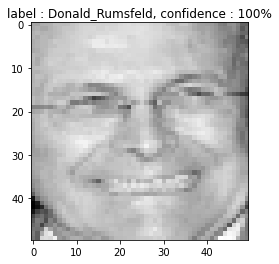

In [59]:
plt.imshow(img, cmap="gray")
plt.title("label : %s, confidence : %2.f%%" % (labels[idx], confidence))
plt.show()

##### 1.6.C Apply to Video frame

In [72]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [74]:
# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

# --------- load tensorflow optimized model ---------
facerecognition_model = "frozen_graph.pb"
net = cv2.dnn.readNet(facerecognition_model)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
layerOutput = net.getUnconnectedOutLayersNames()

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            
            blob = cv2.dnn.blobFromImage(face_img, 1.0, (50, 50), (0, 0, 0), swapRB=True, crop=False)
            net.setInput(blob)
            output = net.forward(layerOutput)
            idx = output[0].argmax(axis=1)[0]
            confidence = output[0].max(axis=1)[0]*100
            
            if confidence > 70:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "N/A"
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Face Recognition', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

# 2. Flask & OpenCV - MJPEG Stream
- **MJPEG stream** working using **Server Push** mechanism.
- Server push is a simple way of **sending file updates to a browser**.
- Most major browsers, and some minor browsers support it for images, with one important exception.
- How it works ?
    - Browser requests a file (typically an image)
    - The server responds with a **multipart mixed-replace** content type header, </br>
        ```
        Content-Type: multipart/x-mixed-replace;boundary=frame
        ```</br>
    - Image from the server is always continue sending image data to browser (client)
    - Image is sender as byte format :</br>
        ```
        --frame
        Content-Type: image/jpeg
        6A3D 5671 55CA 66B7
        611A A10B 1408 246A
        ....
        ....
        ```</br>
<img src="resource/server-toclient.png" style="width:300px"></img></br>
source : [http://www.howtocreate.co.uk/Server Push](http://www.howtocreate.co.uk/php/serverpushdemo.php)

- install flask

In [75]:
! pip install flask

  Using cached Flask-1.1.2-py2.py3-none-any.whl (94 kB)
  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Using cached itsdangerous-1.1.0-py2.py3-none-any.whl (16 kB)
  Using cached Jinja2-2.11.2-py2.py3-none-any.whl (125 kB)
  Using cached MarkupSafe-1.1.1-cp36-cp36m-win_amd64.whl (16 kB)


- Basic Flask : Route & Template
    - run `python 1_Basic_Flask/app.py` in console (cmd)

- Flask & OpenCV : mjpeg stream
    - run `python 2_Mjpeg_Stream/app.py` in console (cmd) </br>
![](resource/opencv_dnn_04.png)

- Facedetection Mjpeg Stream
    - run `python 3_Facedetect_Mjpeg_Stream/app.py` in console (cmd)

- Facerecognition Mjpeg Stream
    - run `python 4_Facerecognition_Mjpeg_Stream/app.py` in console (cmd)

- Modular Version Facerecognition
    - create `labels.csv` to hold all labels data presitent
    - run `python 5_Modular_Version/app.py` on console (cmd)

In [14]:
# save labels to CSV file

import pandas as pd

labels = ['Ariel_Sharon',
          'Colin_Powell',
          'Donald_Rumsfeld',
          'George_W_Bush',
          'Gerhard_Schroeder',
          'Hugo_Chavez',
          'Jacques_Chirac',
          'Jean_Chretien',
          'John_Ashcroft',
          'Junichiro_Koizumi',
          'Serena_Williams',
          'Tony_Blair',
          'Yunus']

labels_df = pd.DataFrame(labels)

labels_df.to_csv("5_Modular_Version/labels.csv",  index=None)